# 6. Upper Limits and the CLs Method

**Pedagogical context.** This notebook covers Cowan's Lecture 12
(interval estimation and setting limits) and the CLs technique
introduced by Read (J. Phys. G28, 2002). The CLs method is the
standard procedure for every LHC search: it sets an upper limit on
the signal strength $\mu$ by scanning $\mu$ and finding where the
modified p-value drops below a threshold.

The CLs method solves a specific problem. A naive frequentist limit
based on CL$_{s+b}$ alone can exclude signal hypotheses to which the
experiment has no sensitivity, simply because a downward background
fluctuation makes any signal look incompatible with the data. The CLs
construction divides CL$_{s+b}$ by CL$_b$ to penalise precisely this
situation. The cost is a slight over-coverage (the limit is conservative),
but the protection against false exclusion is considered essential.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 12, "figure.facecolor": "white"})

from histimator import Histogram, Sample, Channel, Model
from histimator.likelihood import fit
from histimator.cls import (
    build_asimov_model, compute_asimov_sigma,
    cls_observed, cls_expected_band, upper_limit_cls,
)
from histimator.inference import upper_limit

## 6.1 The Asimov dataset

The Asimov dataset is a synthetic dataset where every bin is set to its
expected yield under a given hypothesis. When the background-only
Asimov dataset ($\mu = 0$) is used to evaluate the $\tilde{q}_\mu$
test statistic at some tested $\mu$, the result gives the median
expected test statistic under repeated background-only experiments.
This is the basis for computing the expected limit without running
any pseudo-experiments.

The key insight from CCGV is that the standard deviation of $\hat{\mu}$
can be extracted from the Asimov test statistic:
$\sigma = \mu_{\text{test}} / \sqrt{q_{\mu,\text{Asimov}}}$.

In [2]:
# Build our test model
edges = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0])
signal = Sample("signal", Histogram([3, 10, 15, 10, 3], edges))
signal.add_normfactor("mu", nominal=1.0, bounds=(0.0, 10.0))

background = Sample("background", Histogram([50, 60, 55, 45, 40], edges))
background.add_normsys("bkg_norm", lo=0.9, hi=1.1)

np.random.seed(42)
true_mu = 0.8
exp = true_mu * signal.histogram.values + background.histogram.values
data = np.random.poisson(exp.astype(int))

ch = Channel("SR")
ch.add_sample(signal)
ch.add_sample(background)
ch.set_data(data)

model = Model("cls_demo")
model.add_channel(ch)

# Build the background-only Asimov
asimov_b = build_asimov_model(model, {"mu": 0.0, "bkg_norm": 0.0})
print("Asimov (b-only) data:", asimov_b.data)
print("Observed data:       ", model.data)

# Compute sigma at mu=1
sigma = compute_asimov_sigma(model, "mu", 1.0)
print(f"\nAsimov sigma at mu=1: {sigma:.4f}")

Asimov (b-only) data: [50. 60. 55. 45. 40.]
Observed data:        [49. 74. 57. 55. 49.]

Asimov sigma at mu=1: 0.5399


## 6.2 CLs at a single signal strength

At each tested value of $\mu$, the CLs method computes two p-values.
CL$_{s+b}$ is the probability of observing a test statistic at least
as large as the observed value under the signal-plus-background
hypothesis. CL$_b$ is the same probability under the background-only
hypothesis. CLs = CL$_{s+b}$ / CL$_b$. The signal is excluded at
confidence level $1 - \alpha$ when CLs $< \alpha$ (typically 0.05).

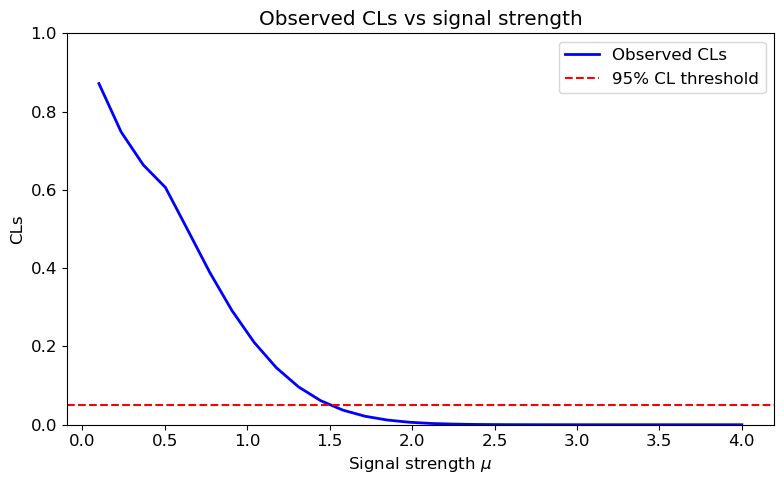

In [3]:
# Compute CLs at several mu values
mu_scan = np.linspace(0.1, 4.0, 30)
cls_obs = [cls_observed(model, "mu", mu_t) for mu_t in mu_scan]

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(mu_scan, cls_obs, "b-", linewidth=2, label="Observed CLs")
ax.axhline(0.05, color="red", ls="--", label="95% CL threshold")
ax.set_xlabel(r"Signal strength $\mu$")
ax.set_ylabel("CLs")
ax.set_title("Observed CLs vs signal strength")
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.show()

## 6.3 The Brazil band

The expected limit and its uncertainty are visualised as the "Brazil
band," named for its resemblance to the Brazilian flag. The median
expected limit is the value of $\mu$ where the expected CLs at the
median background-only quantile crosses 0.05. The green band shows the
$\pm 1\sigma$ range and the yellow band shows $\pm 2\sigma$, reflecting
the range of limits that would be set by typical background fluctuations.

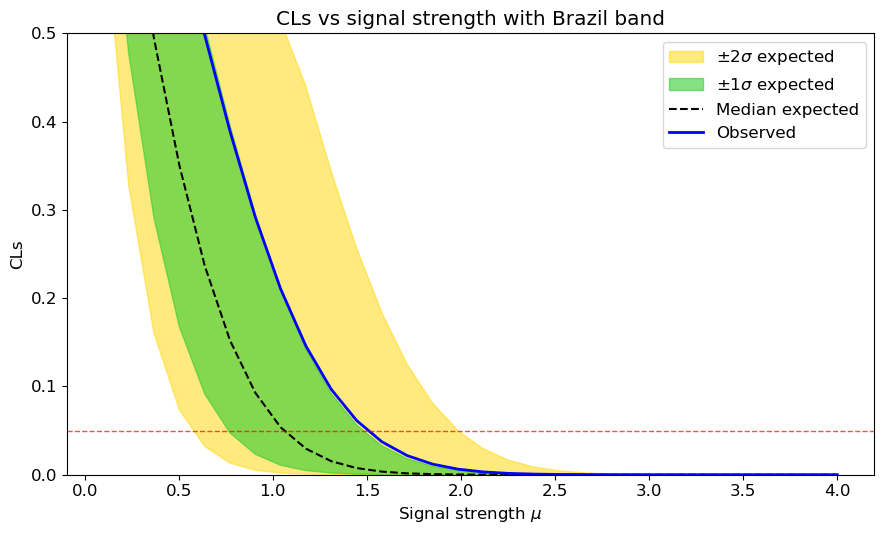

In [4]:
# Expected CLs band at each mu
cls_bands = [cls_expected_band(model, "mu", mu_t) for mu_t in mu_scan]
cls_bands = np.array(cls_bands)  # shape (n_mu, 5)

fig, ax = plt.subplots(figsize=(9, 5.5))

# Yellow band: +/- 2 sigma
ax.fill_between(mu_scan, cls_bands[:, 0], cls_bands[:, 4],
                color="gold", alpha=0.5, label=r"$\pm 2\sigma$ expected")
# Green band: +/- 1 sigma
ax.fill_between(mu_scan, cls_bands[:, 1], cls_bands[:, 3],
                color="limegreen", alpha=0.6, label=r"$\pm 1\sigma$ expected")
# Median expected
ax.plot(mu_scan, cls_bands[:, 2], "k--", linewidth=1.5, label="Median expected")
# Observed
ax.plot(mu_scan, cls_obs, "b-", linewidth=2, label="Observed")
# Threshold
ax.axhline(0.05, color="red", ls="--", alpha=0.7, linewidth=1)

ax.set_xlabel(r"Signal strength $\mu$")
ax.set_ylabel("CLs")
ax.set_title("CLs vs signal strength with Brazil band")
ax.set_ylim(0, 0.5)
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

## 6.4 Computing the upper limit

The `upper_limit_cls` function automates the crossing-point
determination. It uses Brent's method to find where CLs = 0.05 for
both the observed data and each of the five expected quantiles.

In [5]:
obs_limit, exp_band = upper_limit_cls(model, "mu")

print(f"Observed 95% CL upper limit: mu < {obs_limit:.3f}")
print(f"Expected limit (median):     mu < {exp_band['median']:.3f}")
print(f"  +/- 1 sigma: [{exp_band['-1sig']:.3f}, {exp_band['+1sig']:.3f}]")
print(f"  +/- 2 sigma: [{exp_band['-2sig']:.3f}, {exp_band['+2sig']:.3f}]")

# Compare with the simpler PLR-inversion limit
plr_limit = upper_limit(model, "mu", cl=0.95)
print(f"\nPLR-inversion limit: mu < {plr_limit:.3f}")
print("(This is the CL_s+b limit, which can be more aggressive than CLs.)")

Observed 95% CL upper limit: mu < 1.502
Expected limit (median):     mu < 1.058
  +/- 1 sigma: [0.762, 1.475]
  +/- 2 sigma: [0.567, 1.984]

PLR-inversion limit: mu < 1.598
(This is the CL_s+b limit, which can be more aggressive than CLs.)


## 6.5 Interpretation

When the observed limit is weaker than the median expected (the observed
line crosses 0.05 at a higher $\mu$ than the dashed median line), it
means the data contained a slight upward fluctuation that looks
signal-like. When the observed limit is stronger, the data fluctuated
downward.

The width of the green band indicates the precision of the experiment:
a narrow band means the limit is well-determined regardless of
statistical fluctuations. A wide band means the experiment is on the
edge of sensitivity. When the entire green band sits below the
threshold line at a given $\mu$, that signal strength is expected to be
excluded at $1\sigma$ or better.

## 6.6 Effect of systematics on the limit

Systematic uncertainties weaken limits by introducing nuisance parameters
that absorb part of the signal-like excess. We can quantify this by
comparing the limit with and without the background systematic.

In [6]:
# Model without systematic
sig2 = Sample("signal", Histogram([3, 10, 15, 10, 3], edges))
sig2.add_normfactor("mu", nominal=1.0, bounds=(0.0, 10.0))
bkg2 = Sample("background", Histogram([50, 60, 55, 45, 40], edges))
# No normsys attached

ch2 = Channel("SR")
ch2.add_sample(sig2)
ch2.add_sample(bkg2)
ch2.set_data(data)

model_noSyst = Model("no_syst")
model_noSyst.add_channel(ch2)

obs_noSyst, exp_noSyst = upper_limit_cls(model_noSyst, "mu")
print(f"With systematics:    observed = {obs_limit:.3f}, expected = {exp_band['median']:.3f}")
print(f"Without systematics: observed = {obs_noSyst:.3f}, expected = {exp_noSyst['median']:.3f}")
print(f"\nThe systematic weakens the expected limit by "
      f"{(exp_band['median'] / exp_noSyst['median'] - 1) * 100:.1f}%.")

With systematics:    observed = 1.502, expected = 1.058
Without systematics: observed = 1.346, expected = 0.712

The systematic weakens the expected limit by 48.7%.


## Exercises

**Exercise 6.1.** Build a model with a larger signal (double the
template values) and compute the CLs limit. How does the expected limit
change? Explain the result in terms of signal-to-background ratio.

**Exercise 6.2.** Add a control region to the model that constrains the
background normalisation. Compare the expected limit with and without
the control region. Quantify the improvement.

**Exercise 6.3.** Plot the full Brazil band (as in Section 6.3) for a
model with 20% background uncertainty. Then overlay the band for 5%
uncertainty on the same plot. Discuss how the width of the band changes.

## References

A. L. Read. "Presentation of search results: the CLs technique."
J. Phys. G28 (2002) 2693-2704.

G. Cowan, K. Cranmer, E. Gross, O. Vitells. arXiv:1007.1727.

G. Cowan, *Statistical Data Analysis*, Lecture 12.